In [1]:
import pandas as pd
import numpy as np
import pathlib as pl

from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

from scipy.stats import mannwhitneyu, fisher_exact, pearsonr, kruskal

In [2]:
import sys
sys.path.append("../../FinalCode/")
import download.download as dwnl
import utils.plotting as plting
import adVMP.adVMP_discovery as discov
import adVMP.adVMP_plots as advmpplt

In [3]:
# For figures
colors = sns.color_palette("muted")
palette = {"Normal": colors[0], "NADJ-A": colors[3], "NADJ-C": colors[2], "Adenoma": colors[3], "SSL": colors[4], "Cancer": colors[5]}
fig_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/ArticleFigures/unit")

In [4]:
base_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/sesame_processed_EPIC/")
base_dir4 = pl.Path("/Users/josephineyates/Documents/CRC_polyp/sesame_processed_EPIC4/")

data_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/FinalData/")

bad_probes = pd.read_csv(data_dir / "auxiliary" / "sketchy_probe_list_epic.csv",index_col=0).values.ravel()
sample_origin_path = pl.Path(data_dir / "clinical" / "sample_origin_wbatch.csv")

clinical_path = pl.Path(data_dir / "clinical" / "cleaned_clinical_reduced_diet.csv")
target_path = pl.Path(data_dir / "clinical" / "targets.csv")

In [5]:
EPIC2_b, EPIC2_clin, EPIC2_samples, EPIC2_phenotypes, EPIC3_b, EPIC3_clin, EPIC3_samples, EPIC3_phenotypes = dwnl.download_EPIC(sample_origin_path=sample_origin_path, 
                     base_dir=base_dir, clinical_path=clinical_path, target_path=target_path,
                  bad_probes=bad_probes, EPIC4=False) 

30it [00:03,  7.75it/s]


In [6]:
EPIC4_b, EPIC4_clin, EPIC4_samples, EPIC4_phenotypes = dwnl.download_EPIC(sample_origin_path=sample_origin_path, 
                     base_dir=base_dir4, clinical_path=clinical_path, target_path=target_path, 
                  bad_probes=bad_probes, EPIC4=True) 

18it [00:03,  5.38it/s]


# Find adVMP

In [7]:
resdir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/FinalData/adVMP")

In [9]:
test_results = discov.get_hyper_vDMC(methylation=EPIC2_b, phenotypes=EPIC2_phenotypes)

100%|█████████████████████████████████| 324053/324053 [04:32<00:00, 1190.82it/s]


In [11]:
test_results.to_csv(resdir / "adVMP_SWEPIC1_right.csv")

In [12]:
test_results = discov.get_hyper_vDMC(methylation=EPIC3_b, phenotypes=EPIC3_phenotypes)

100%|█████████████████████████████████| 324053/324053 [04:41<00:00, 1152.19it/s]


In [13]:
test_results.to_csv(resdir / "adVMP_SWEPIC2_right.csv")

In [14]:
test_results = discov.get_hyper_vDMC(methylation=EPIC4_b, phenotypes=EPIC4_phenotypes)

100%|█████████████████████████████████| 306651/306651 [04:38<00:00, 1100.62it/s]


In [15]:
test_results.to_csv(resdir / "adVMP_SWEPIC3_right.csv")

# Ensembling probes

In [8]:
test_results = {}
for i in ['1','2','3']:
    test_results[i]  = pd.read_csv(resdir / f"adVMP_SWEPIC{i}_right.csv", index_col=0)

In [9]:
sign_probes = {}
for i in test_results:
    sign_probes[i] = test_results[i][(test_results[i]["q"]<0.001) & (test_results[i]["ttest_p"]<0.05) & (test_results[i]["diffV"]>0)]

In [10]:
sel_cpgs = [sign_probes["1"].index.intersection(sign_probes["2"].index)]
sel_cpgs.append(sign_probes["1"].index.intersection(sign_probes["3"].index))
sel_cpgs.append(sign_probes["2"].index.intersection(sign_probes["3"].index))
union_cpgs = np.unique(np.concatenate(sel_cpgs))

union_cpgs = np.intersect1d(union_cpgs,EPIC4_b.columns)

In [11]:
all_advmps = np.unique(np.concatenate([sign_probes["1"].index,sign_probes["2"].index,sign_probes["3"].index]))

In [14]:
pd.Series(union_cpgs).to_csv(resdir / "union_cpgs.csv")
pd.Series(all_advmps).to_csv(resdir / "all_advmps.csv")

In [11]:
# library
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

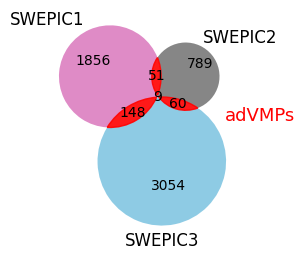

In [41]:
set1 = set(sign_probes["1"].index.intersection(EPIC4_b.columns))
set2 = set(sign_probes["2"].index.intersection(EPIC4_b.columns))
set3 = set(sign_probes["3"].index)
plt.figure(figsize=(3,3))
v = venn3([set1, set2, set3], ('SWEPIC1', 'SWEPIC2', 'SWEPIC3'), 
      set_colors=(colors[6], colors[7], colors[9]), alpha=0.9)
v.get_patch_by_id('110').set_color("r")
v.get_patch_by_id('101').set_color("r")
v.get_patch_by_id('011').set_color("r")
plt.text(0.5,0,'adVMPs',c="r",fontsize=13)
plt.gcf().savefig(fig_dir / "venn_diagram_union_probes.svg", dpi=250, bbox_inches="tight")

# Visualize probe performance

In [12]:
heatmap_df1, hit_fraction1 = discov.get_heatmap_df(selcpgs=union_cpgs, EPIC_m=EPIC2_b, phenotypes=EPIC2_phenotypes)

heatmap_df2, hit_fraction2 = discov.get_heatmap_df(selcpgs=union_cpgs, EPIC_m=EPIC3_b, phenotypes=EPIC3_phenotypes)

heatmap_df3, hit_fraction3 = discov.get_heatmap_df(selcpgs=union_cpgs, EPIC_m=EPIC4_b, phenotypes=EPIC4_phenotypes)

/Users/josephineyates/opt/anaconda3/envs/methylation/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../..

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.421e-10 U_stat=9.495e+02


/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


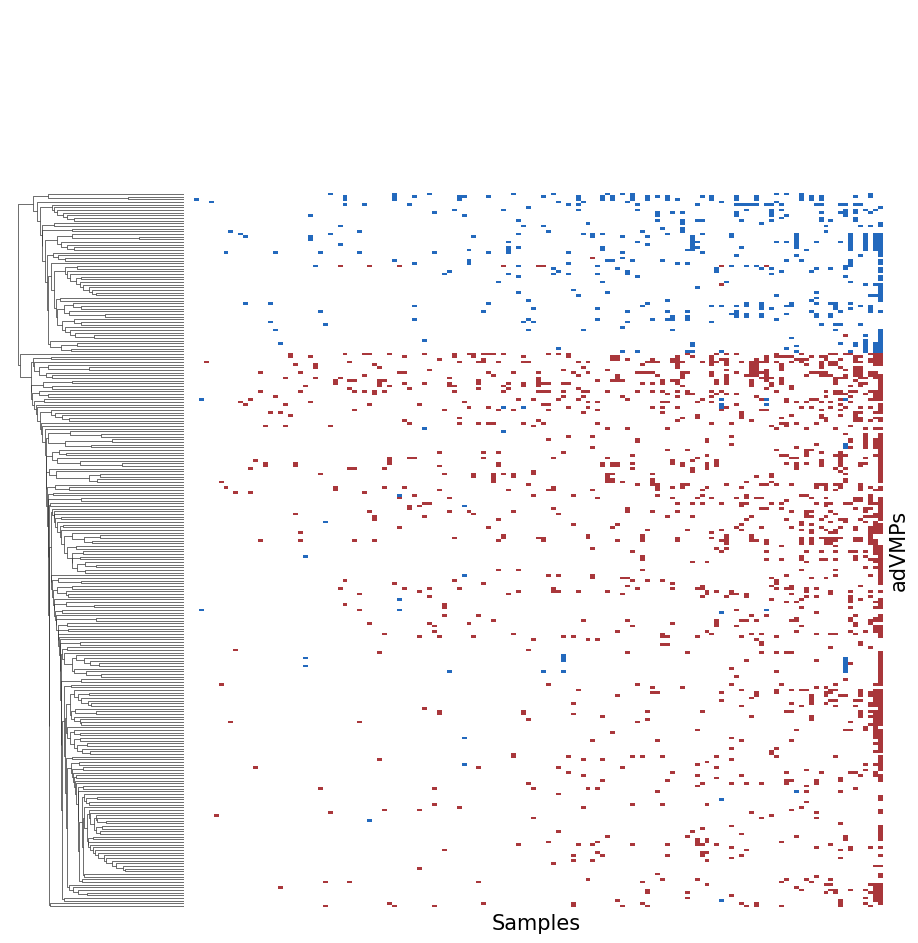

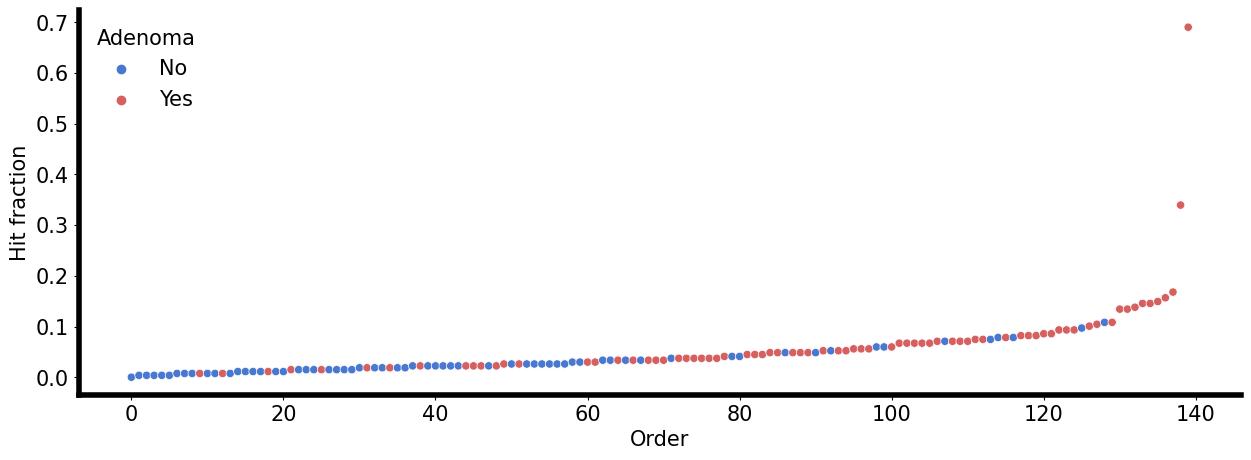

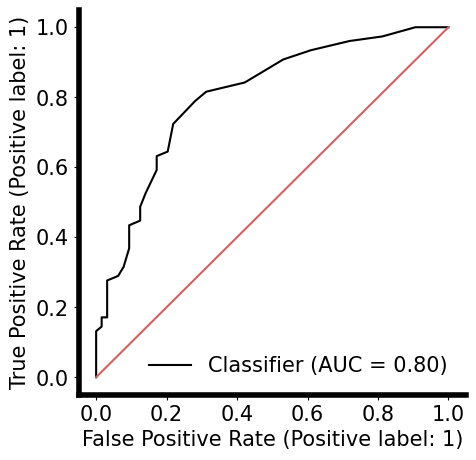

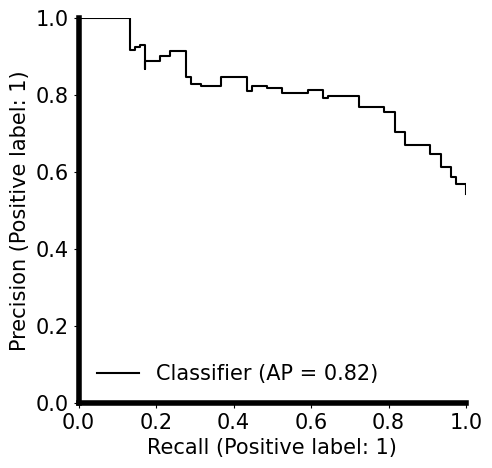

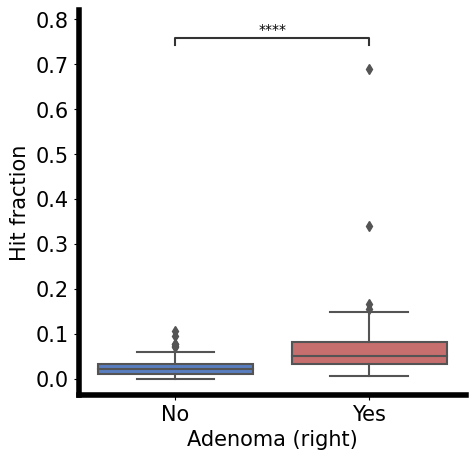

In [17]:
advmpplt.get_performance_plots(
    heatmap_df=heatmap_df1,
    fig_dir=fig_dir / "SWEPIC1", hue_worm="Ad_plot",
    hue_palette_worm={"No": colors[0], "Yes": colors[3]}, 
    ftsize=15, leg_ftsize=15, figsize=5,
)

/Users/josephineyates/opt/anaconda3/envs/methylation/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../..

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.294e-05 U_stat=9.450e+03


/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


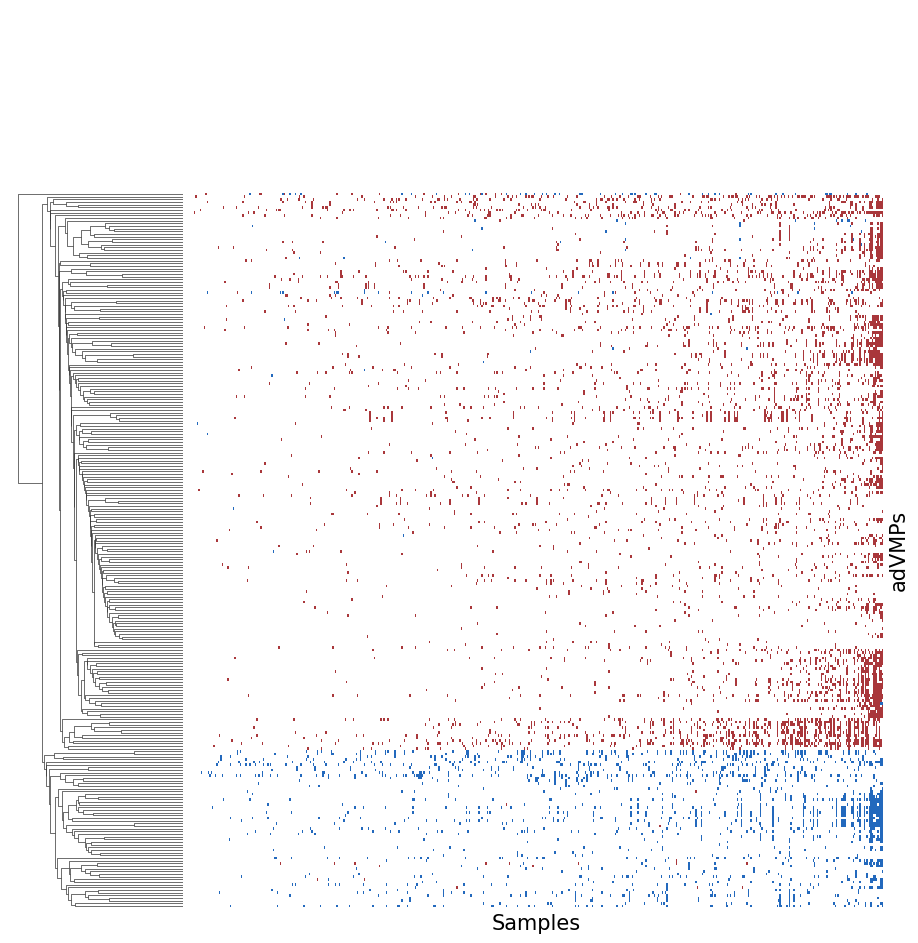

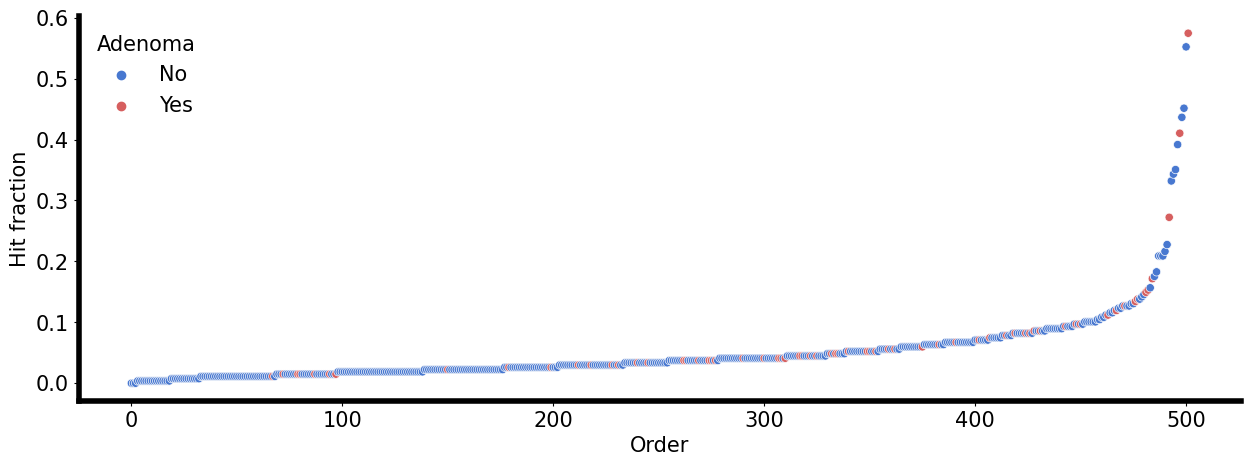

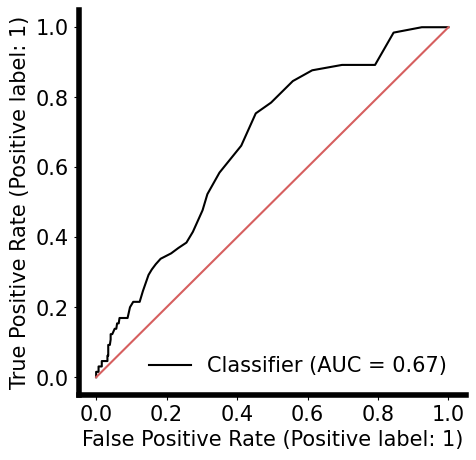

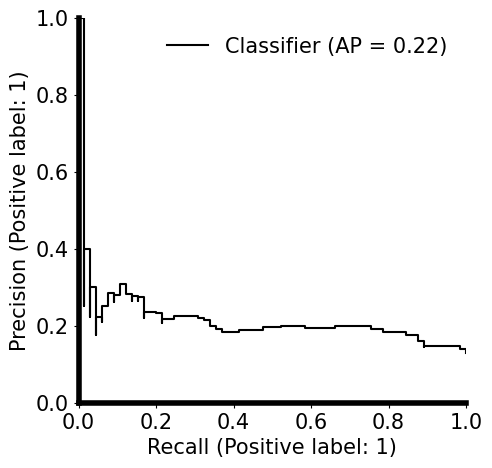

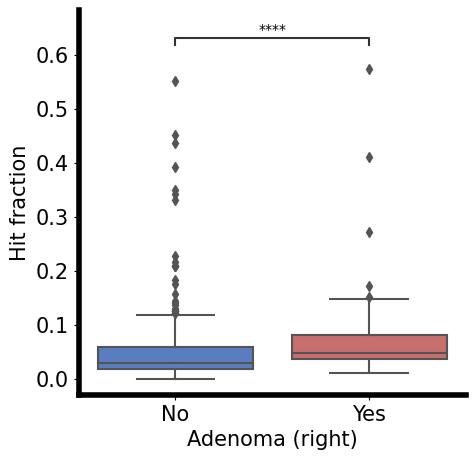

In [20]:
advmpplt.get_performance_plots(
    heatmap_df=heatmap_df2,
    fig_dir=fig_dir / "SWEPIC2", hue_worm="Ad_plot",
    hue_palette_worm={"No": colors[0], "Yes": colors[3]}, 
    ftsize=15, leg_ftsize=15, figsize=5,
)

/Users/josephineyates/opt/anaconda3/envs/methylation/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../..

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.239e-15 U_stat=1.489e+04


/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


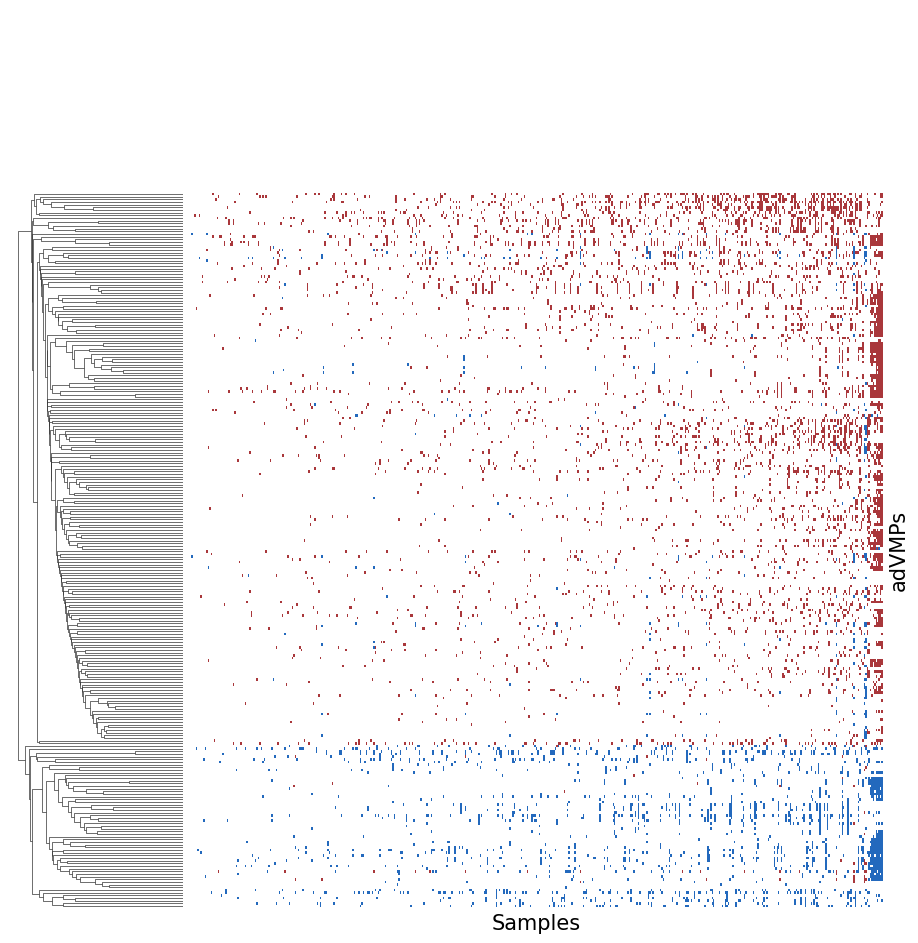

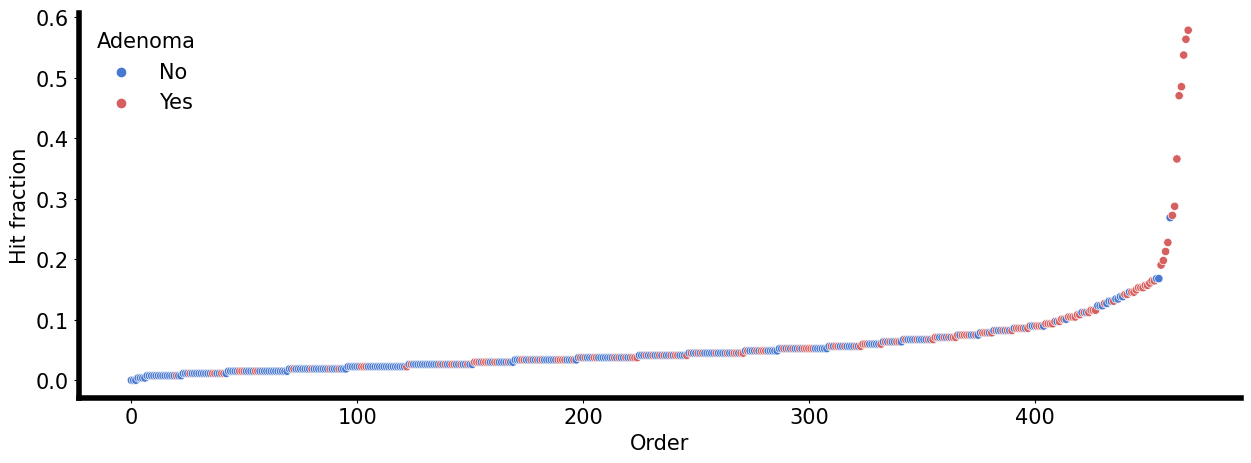

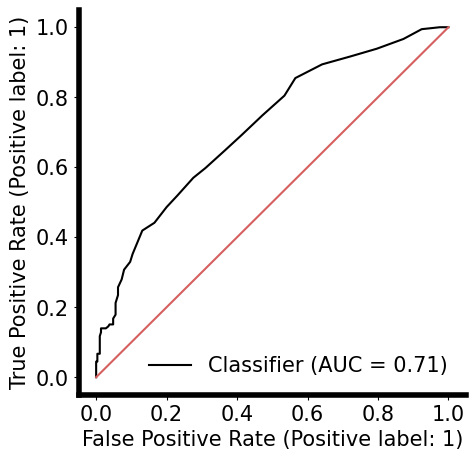

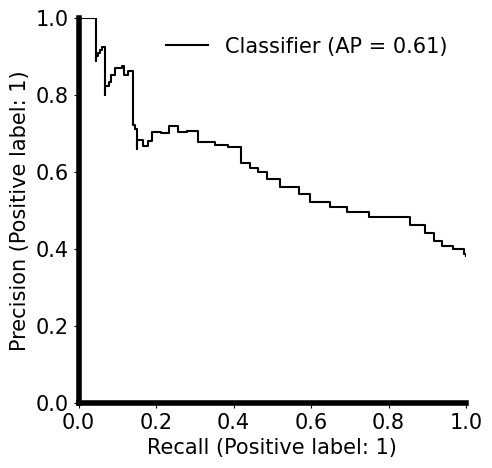

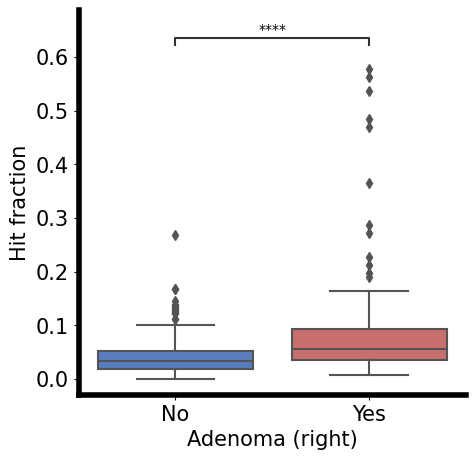

In [21]:
advmpplt.get_performance_plots(
    heatmap_df=heatmap_df3,
    fig_dir=fig_dir / "SWEPIC3", hue_worm="Ad_plot",
    hue_palette_worm={"No": colors[0], "Yes": colors[3]}, 
    ftsize=15, leg_ftsize=15, figsize=5,
)

# Hit fraction

In [13]:
dfs = []
df1 = heatmap_df1[["Hit fraction","Ad_plot","Order"]]
df1 = pd.concat([df1,pd.DataFrame(["SWEPIC1"]*df1.shape[0],
                                      index=df1.index,columns=["Batch"])],axis=1)
dfs.append(df1)
df2 = heatmap_df2[["Hit fraction","Ad_plot","Order"]]
df2 = pd.concat([df2,pd.DataFrame(["SWEPIC2"]*df2.shape[0],
                                      index=df2.index,columns=["Batch"])],axis=1)
dfs.append(df2)
df3 = heatmap_df3[["Hit fraction","Ad_plot","Order"]]
df3 = pd.concat([df3,pd.DataFrame(["SWEPIC3"]*df3.shape[0],
                                      index=df3.index,columns=["Batch"])],axis=1)
dfs.append(df3)

In [14]:
df = pd.concat(dfs)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SWEPIC2_No vs. SWEPIC2_Yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.294e-05 U_stat=9.450e+03
SWEPIC1_No vs. SWEPIC1_Yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.421e-10 U_stat=9.495e+02
SWEPIC3_No vs. SWEPIC3_Yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.239e-15 U_stat=1.489e+04


/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


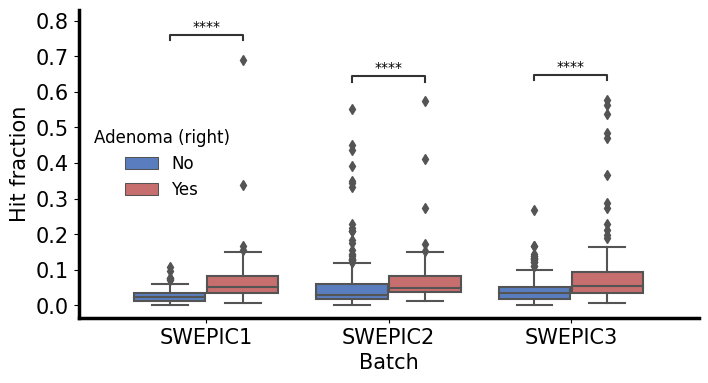

In [15]:
fig, ax= plt.subplots(1,1, figsize=(8,4))
sns.boxplot(data=df, x="Batch", y="Hit fraction", hue="Ad_plot", palette={"No": colors[0], "Yes": colors[3]})
annot = Annotator(
        ax,
        pairs=[(("SWEPIC1", "No"),("SWEPIC1", "Yes")),
               (("SWEPIC2", "No"),("SWEPIC2", "Yes")),
               (("SWEPIC3", "No"),("SWEPIC3", "Yes"))],
        data=df, x="Batch", y="Hit fraction", hue="Ad_plot",
    )
annot.configure(
        test="Mann-Whitney",
        loc="inside",
        show_test_name=False,
        verbose=2,
        comparisons_correction="BH",
        correction_format="replace",
    )
annot.apply_test()
ax, _ = annot.annotate()
plting.transform_plot_ax(ax, legend_title="Adenoma (right)",linew=2.5)
fig.savefig(fig_dir / "hit_fraction_dist.svg", bbox_inches="tight")

/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebook

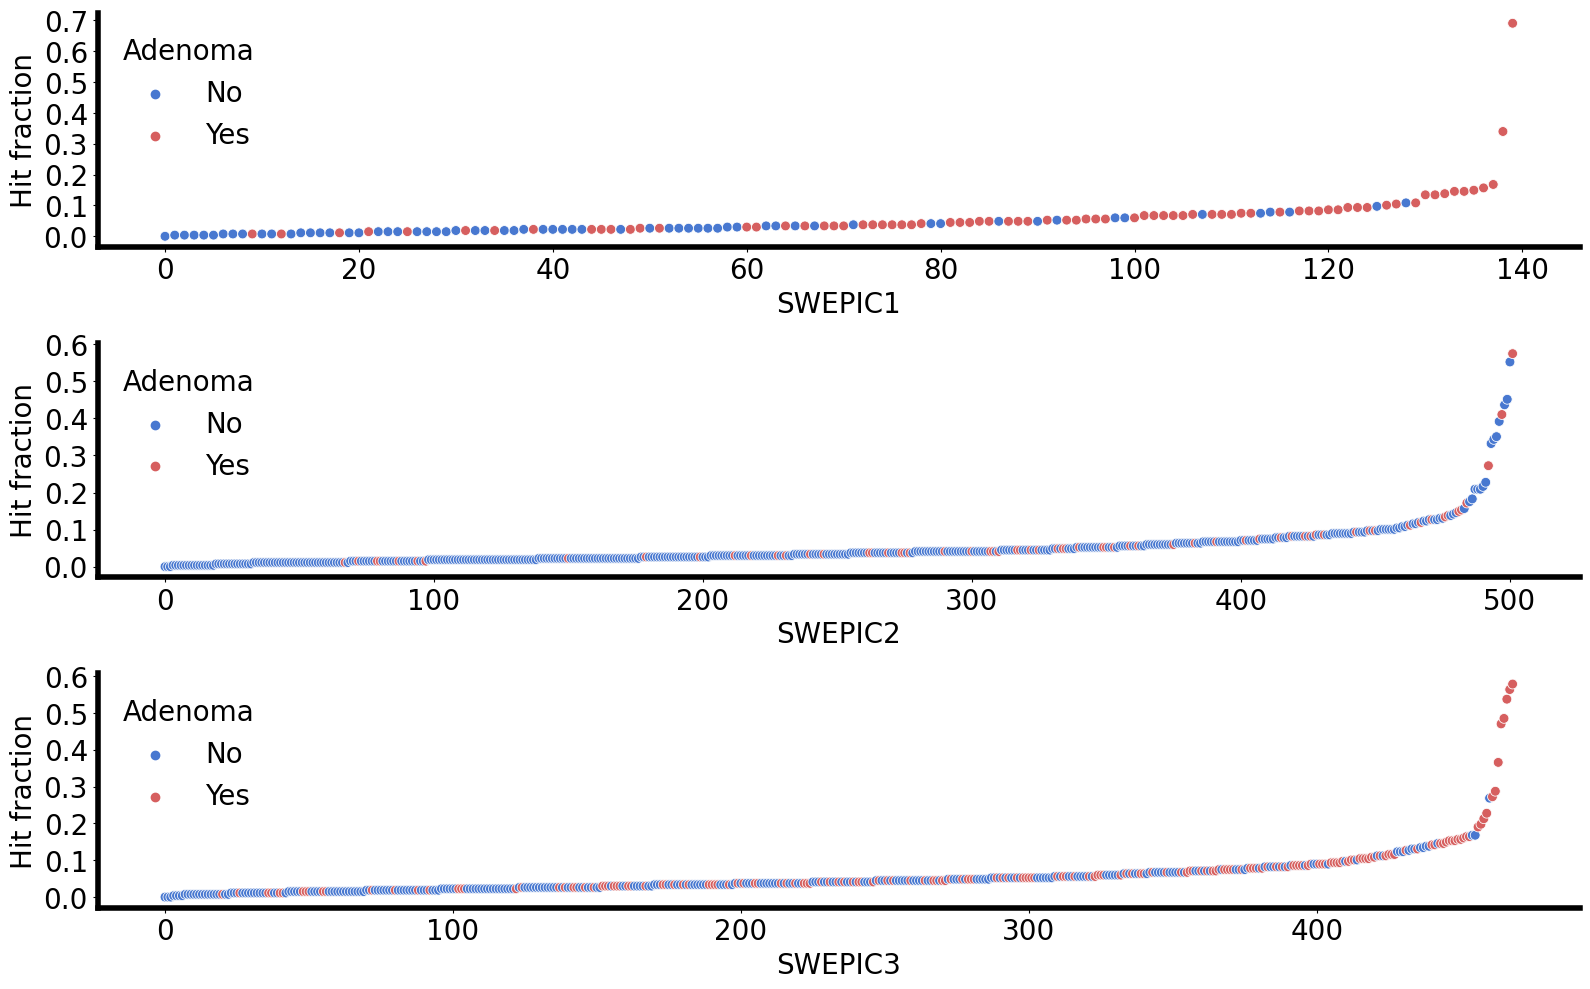

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(16,10))
flatax = ax.flatten()
for i in range(len(flatax)):
    
    sns.scatterplot(
        data=dfs[i],
        x="Order",
        y="Hit fraction",
        hue="Ad_plot", s=50,
        palette={"No": colors[0], "Yes": colors[3]}, ax=flatax[i],
    )
    plting.transform_plot_ax(flatax[i], legend_title="Adenoma", ftsize=20, leg_ftsize=20)
    flatax[i].set_xlabel(f"SWEPIC{i+1}", fontsize=20)
fig.tight_layout()
fig.savefig(fig_dir / "worm_plot_full_swepic.svg", bbox_inches="tight")

In [51]:
from scipy.stats import spearmanr

In [52]:
r1, p1 = spearmanr(heatmap_df1["Ad"],heatmap_df1["Hit fraction"])
r2, p2 = spearmanr(heatmap_df2["Ad"],heatmap_df2["Hit fraction"])
r3, p3 = spearmanr(heatmap_df3["Ad"],heatmap_df3["Hit fraction"])

In [53]:
r1, r2, r3

(0.5265992731019892, 0.1948575209076149, 0.3589000746286538)

In [54]:
p1, p2, p3

(2.3432233401103708e-11, 1.0966275105354766e-05, 1.0530924250053347e-15)

# Compare with polyp size

In [55]:
palette_size = {"None": colors[0], "5mm": colors[3], ">=6mm": colors[1]}
palette_nr = {"0": colors[0], "1": colors[3], ">=2": colors[1]}

In [56]:
heatmap_polyp1 = discov.get_polyp_size_nr_link(EPIC_clin=EPIC2_clin, heatmap_df=heatmap_df1)
heatmap_polyp2 = discov.get_polyp_size_nr_link(EPIC_clin=EPIC3_clin, heatmap_df=heatmap_df2)
heatmap_polyp3 = discov.get_polyp_size_nr_link(EPIC_clin=EPIC4_clin, heatmap_df=heatmap_df3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

None vs. 5mm: Mann-Whitney-Wilcoxon test two-sided, P_val:1.758e-08 U_stat=7.615e+02
5mm vs. >=6mm: Mann-Whitney-Wilcoxon test two-sided, P_val:1.441e-01 U_stat=2.600e+02
None vs. >=6mm: Mann-Whitney-Wilcoxon test two-sided, P_val:5.726e-02 U_stat=1.815e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:7.009e-08 U_stat=7.285e+02
1 vs. >=2: Mann-Whitney-Wilcoxon test two-sided, P_val:4.639e-01 U_stat=3.645e+02
0 vs. >=2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.063e-04 U_stat=2.810e+02


/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.077e-03 U_stat=4.720e+02
1 vs. >=2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.075e-03 U_stat=6.785e+02
0 vs. >=2: Mann-Whitney-Wilcoxon test two-sided, P_val:3.509e-09 U_stat=3.975e+02


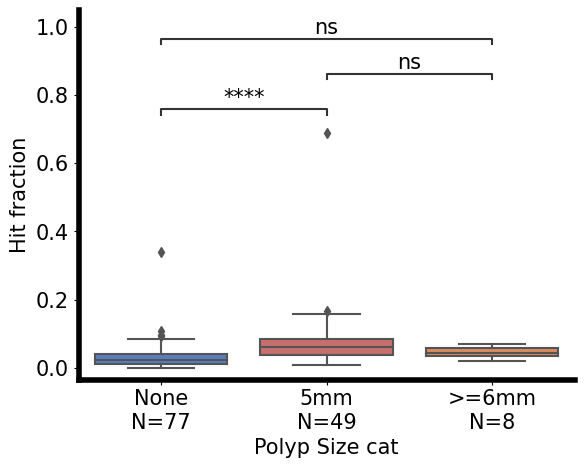

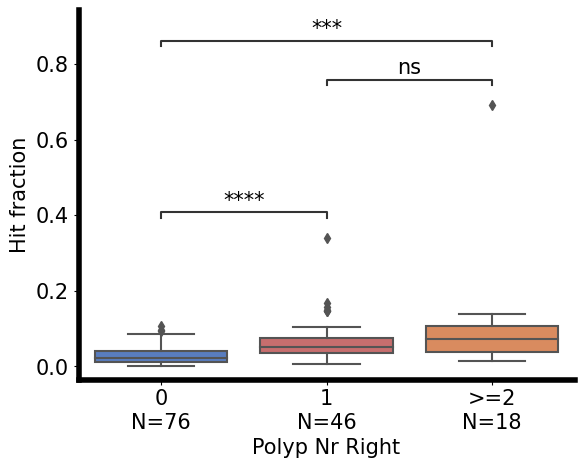

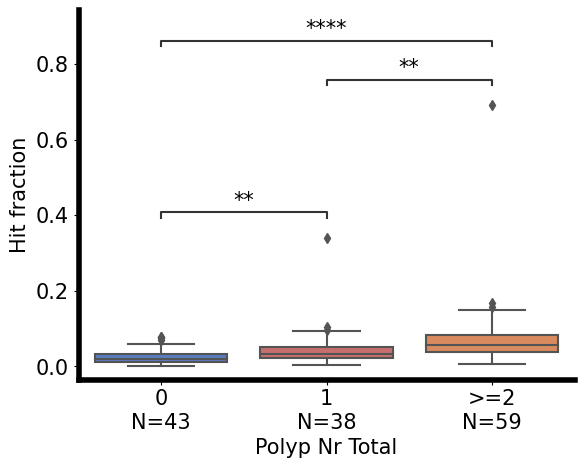

In [57]:
advmpplt.plot_polyp_size_nr_link(heatmap_df=heatmap_polyp1, 
                            fig_dir=fig_dir/"SWEPIC1", 
                        palette_size=palette_size, 
                        palette_nr=palette_nr, ftsize=15, leg_ftsize=15)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

None vs. 5mm: Mann-Whitney-Wilcoxon test two-sided, P_val:5.496e-04 U_stat=5.428e+03
5mm vs. >=6mm: Mann-Whitney-Wilcoxon test two-sided, P_val:7.693e-01 U_stat=2.275e+02
None vs. >=6mm: Mann-Whitney-Wilcoxon test two-sided, P_val:2.211e-01 U_stat=1.802e+03
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:4.897e-03 U_stat=5.934e+03
1 vs. >=2: Mann-Whitney-Wilcoxon test two-sided, P_val:3.479e-01 U_stat=9.825e+02
0 vs. >=2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.297e-01 U_stat=8.114e+03


/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:3.526e-01 U_stat=1.748e+04
1 vs. >=2: Mann-Whitney-Wilcoxon test two-sided, P_val:6.366e-01 U_stat=4.450e+03
0 vs. >=2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.597e-01 U_stat=1.035e+04


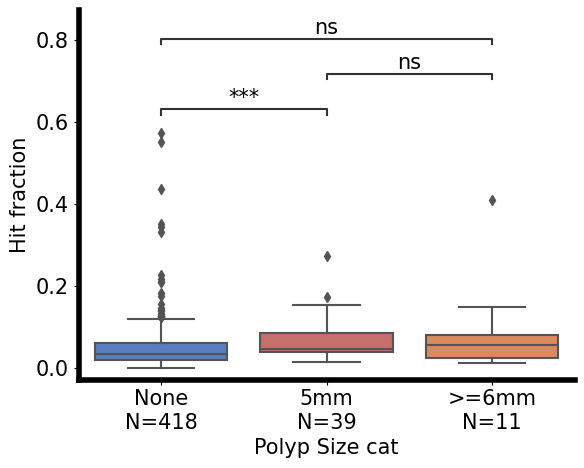

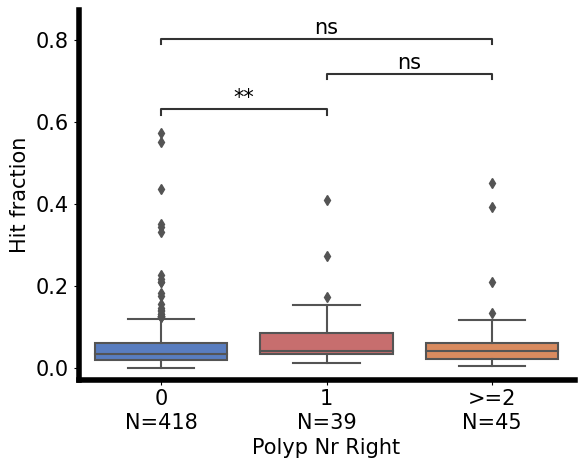

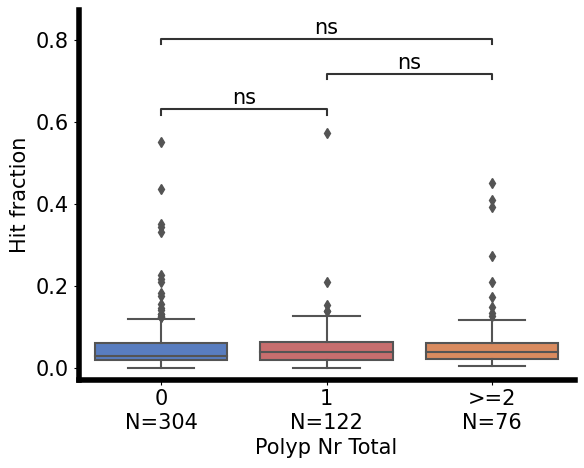

In [58]:
advmpplt.plot_polyp_size_nr_link(heatmap_df=heatmap_polyp2, 
                            fig_dir=fig_dir/"SWEPIC2", 
                        palette_size=palette_size, 
                        palette_nr=palette_nr, ftsize=15, leg_ftsize=15)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

None vs. 5mm: Mann-Whitney-Wilcoxon test two-sided, P_val:7.793e-08 U_stat=8.708e+03
5mm vs. >=6mm: Mann-Whitney-Wilcoxon test two-sided, P_val:8.818e-02 U_stat=1.108e+03
None vs. >=6mm: Mann-Whitney-Wilcoxon test two-sided, P_val:7.134e-06 U_stat=2.441e+03
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.208e-09 U_stat=9.986e+03
1 vs. >=2: Mann-Whitney-Wilcoxon test two-sided, P_val:5.436e-02 U_stat=3.426e+03
0 vs. >=2: Mann-Whitney-Wilcoxon test two-sided, P_val:3.197e-02 U_stat=6.796e+03


/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.608e-04 U_stat=5.558e+03
1 vs. >=2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.765e-01 U_stat=3.867e+03
0 vs. >=2: Mann-Whitney-Wilcoxon test two-sided, P_val:5.322e-12 U_stat=1.116e+04


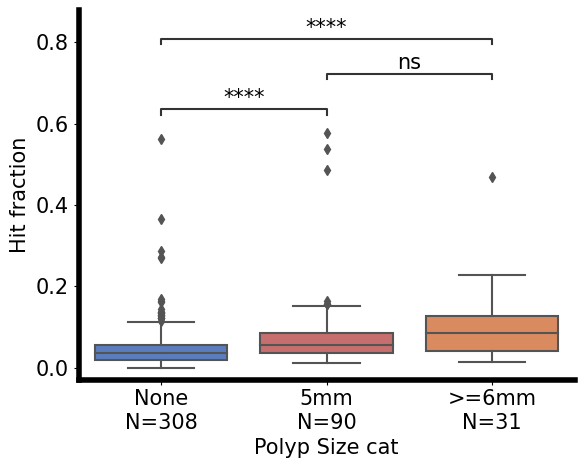

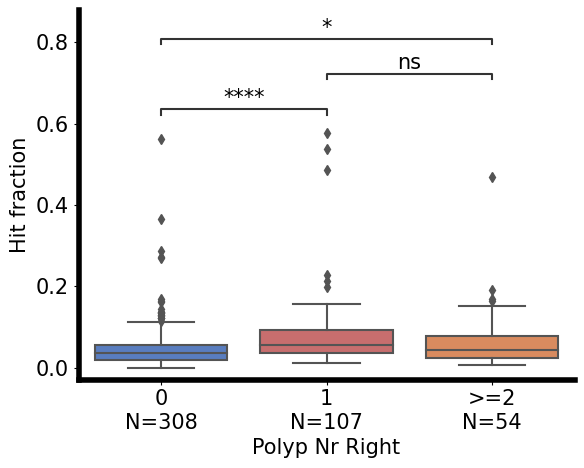

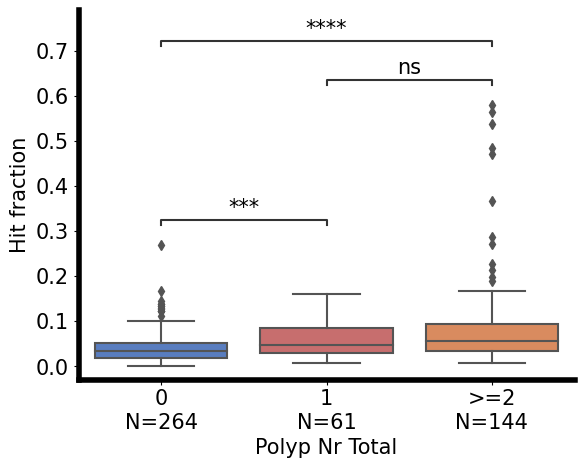

In [59]:
advmpplt.plot_polyp_size_nr_link(heatmap_df=heatmap_polyp3, 
                            fig_dir=fig_dir/"SWEPIC3", 
                        palette_size=palette_size, 
                        palette_nr=palette_nr, ftsize=15, leg_ftsize=15)

In [60]:
cols = ['Ad', 'Hit fraction',
       'Ad_plot', 'Order', 'polyps_total_nr', 'polyps_total_size',
       'polyps_right_nr', 'size_py_rght', 'Polyp Nr Right', 'Polyp Nr Total',
       'Polyp Size cat', 'Polyp Size Total cat']
heatmap_polyp = pd.concat([heatmap_polyp1[cols],heatmap_polyp2[cols],heatmap_polyp3[cols]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

None vs. 5mm: Mann-Whitney-Wilcoxon test two-sided, P_val:2.026e-16 U_stat=4.338e+04
5mm vs. >=6mm: Mann-Whitney-Wilcoxon test two-sided, P_val:4.897e-01 U_stat=4.165e+03
None vs. >=6mm: Mann-Whitney-Wilcoxon test two-sided, P_val:2.601e-06 U_stat=1.214e+04
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.795e-16 U_stat=4.760e+04
1 vs. >=2: Mann-Whitney-Wilcoxon test two-sided, P_val:3.393e-02 U_stat=1.285e+04
0 vs. >=2: Mann-Whitney-Wilcoxon test two-sided, P_val:9.377e-05 U_stat=3.645e+04


/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.031e-03 U_stat=5.748e+04
1 vs. >=2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.482e-04 U_stat=2.475e+04
0 vs. >=2: Mann-Whitney-Wilcoxon test two-sided, P_val:4.838e-16 U_stat=5.639e+04


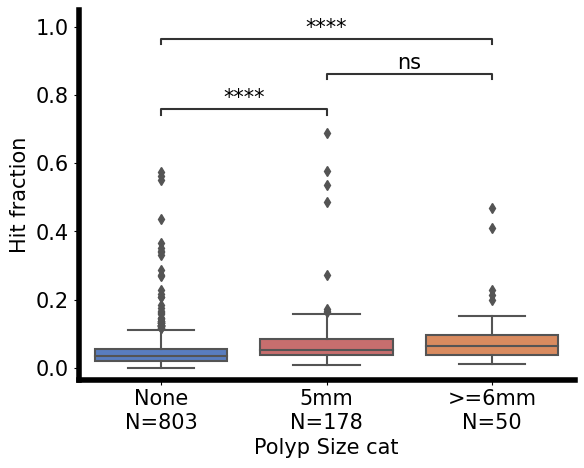

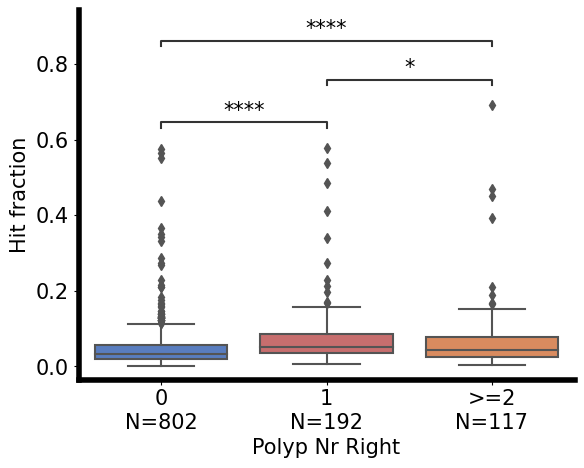

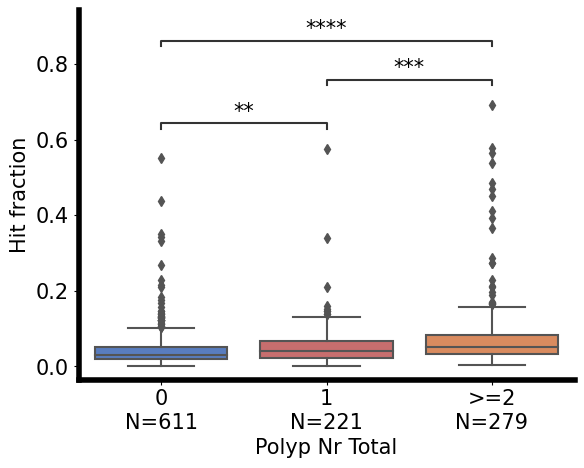

In [61]:
advmpplt.plot_polyp_size_nr_link(heatmap_df=heatmap_polyp, 
                            fig_dir=fig_dir, 
                        palette_size=palette_size, 
                        palette_nr=palette_nr, ftsize=15, leg_ftsize=15)

# Link with cell type composition (deconvolution)

In [15]:
deconv4 = pd.read_csv("/Users/josephineyates/Documents/CRC_polyp/FinalData/EpiSCORE_results/epic4_estimates.csv",index_col=0)
deconv4.index = deconv4.index.astype(str)
deconv123 = pd.read_csv("/Users/josephineyates/Documents/CRC_polyp/FinalData/EpiSCORE_results/epic123_estimates.csv",index_col=0)
deconv123.index = deconv123.index.astype(str)

deconv = pd.concat([deconv123,deconv4])

deconv = pd.concat([df,deconv.loc[df.index]],axis=1)

In [23]:
from scipy.stats import pearsonr
for ct in ["EC","Epi","Lym","Mye","Stromal"]:
    print(pearsonr(deconv["Hit fraction"].ravel(),deconv[ct].ravel()))


PearsonRResult(statistic=-0.049462294796836816, pvalue=0.09939095231132437)
PearsonRResult(statistic=0.1094357052868597, pvalue=0.00025763400816040016)
PearsonRResult(statistic=-0.1553128504421466, pvalue=1.9650996514035636e-07)
PearsonRResult(statistic=-0.09807126073332846, pvalue=0.001063779525008112)
PearsonRResult(statistic=0.06238335713504629, pvalue=0.03761498481966321)


# Extra: select patients in Kaspar cohort

In [17]:
institution = pd.read_csv("../../FinalData/clinical/institution_information.csv",index_col=0)

In [18]:
kaspar_pat = institution[institution["Institution"]=="55"].index

In [19]:
sample_origin = pd.read_csv(sample_origin_path,index_col=0)
sample_origin.index = sample_origin.index.astype(str)

In [20]:
sample_origin = sample_origin[(sample_origin["specimen_type"]=="cecum")]

In [21]:
sample_origin = sample_origin[sample_origin["patient_id"].isin(kaspar_pat)]

In [22]:
sample_origin = sample_origin.dropna()

In [23]:
swepic1_kasp = heatmap_df1.loc[heatmap_df1.index.intersection(sample_origin.index),["Hit fraction","Ad"]]
swepic1_kasp = pd.concat([swepic1_kasp,sample_origin.loc[swepic1_kasp.index]],axis=1)
swepic2_kasp = heatmap_df2.loc[heatmap_df2.index.intersection(sample_origin.index),["Hit fraction","Ad"]]
swepic2_kasp = pd.concat([swepic2_kasp,sample_origin.loc[swepic2_kasp.index]],axis=1)
swepic3_kasp = heatmap_df3.loc[heatmap_df3.index.intersection(sample_origin.index),["Hit fraction","Ad"]]
swepic3_kasp = pd.concat([swepic3_kasp,sample_origin.loc[swepic3_kasp.index]],axis=1)

In [85]:
followup_EPIC2 = pd.concat([swepic1_kasp[swepic1_kasp["Ad"]==0].head(15),
           swepic1_kasp[swepic1_kasp["Ad"]==0].tail(15), 
           swepic1_kasp[swepic1_kasp["Ad"]==1].head(5), 
           swepic1_kasp[swepic1_kasp["Ad"]==1].tail(5)])

In [86]:
followup_EPIC3 = pd.concat([swepic2_kasp[swepic2_kasp["Ad"]==0].head(15),
           swepic2_kasp[swepic2_kasp["Ad"]==0].tail(15), 
           swepic2_kasp[swepic2_kasp["Ad"]==1].head(5), 
           swepic2_kasp[swepic2_kasp["Ad"]==1].tail(5)])

In [87]:
followup_EPIC4 = pd.concat([swepic3_kasp[swepic3_kasp["Ad"]==0].head(15),
           swepic3_kasp[swepic3_kasp["Ad"]==0].tail(15), 
           swepic3_kasp[swepic3_kasp["Ad"]==1].head(5), 
           swepic3_kasp[swepic3_kasp["Ad"]==1].tail(5)])

In [89]:
followup_EPIC2.to_csv("/Users/josephineyates/Documents/CRC_polyp/data/patients_followup/EPIC2_follow_up.csv")

In [90]:
followup_EPIC3.to_csv("/Users/josephineyates/Documents/CRC_polyp/data/patients_followup/EPIC3_follow_up.csv")

In [91]:
followup_EPIC4.to_csv("/Users/josephineyates/Documents/CRC_polyp/data/patients_followup/EPIC4_follow_up.csv")

In [29]:
followup_EPIC2_recurrence = pd.concat([swepic1_kasp[swepic1_kasp["Ad"]==1].head(20),
                                       swepic1_kasp[swepic1_kasp["Ad"]==1].tail(20)])

In [31]:
followup_EPIC3_recurrence = pd.concat([swepic2_kasp[swepic2_kasp["Ad"]==1].head(20),
                                       swepic2_kasp[swepic2_kasp["Ad"]==1].tail(20)])

In [33]:
followup_EPIC4_recurrence = pd.concat([swepic3_kasp[swepic3_kasp["Ad"]==1].head(20),
                                       swepic3_kasp[swepic3_kasp["Ad"]==1].tail(20)])

In [35]:
followup_EPIC2_recurrence.to_csv("/Users/josephineyates/Documents/CRC_polyp/data/patients_followup/EPIC2_follow_up_recurrence.csv")

In [36]:
followup_EPIC3_recurrence.to_csv("/Users/josephineyates/Documents/CRC_polyp/data/patients_followup/EPIC3_follow_up_recurrence.csv")

In [37]:
followup_EPIC4_recurrence.to_csv("/Users/josephineyates/Documents/CRC_polyp/data/patients_followup/EPIC4_follow_up_recurrence.csv")